# Non-negative matrix factorization and recommender systems

So far, we have considered models that predicted *one* dependent variable from *several independent*. In the scenario of a recommendation system, we have built a model for each user.

The main motivation of methods for recommending systems is that user models are *not independent*. We want a single model that will evaluate any combination of user and product, and implicitly exploit mutual information between different user models.

One of the models that are very commonly used in practice is the model of matrix factorization.
This assumes a matrix of users and products that we present as a product of two matrices of a *lower rank*. The latter property allows compressing information and concluding new (unobserved, missing values) in the original matrix.

<img width=450 src="slike/nmf-shema.png"/>

## Introductory definitions

We can present the data matrix $\mathbf{X}$ containing missing values with the matrix factorization model as follows:
$$ \mathbf{X} = \mathbf{W} \mathbf{H}^T + \mathbf{E} $$,

therefore as a product of the $\mathbf{W}$ matrix representing the row space, $\mathbf{H}$ represents the column space, and $\mathbf{E}$ is the residue or error. The $\mathbf{W}, \mathbf{H}$ matrices are sometimes represented as a concurrent clustering of columns and rows. Matrices are of the following sizes:
$$ \mathbf{X} \in \mathbb{R}^{m \times n}, \mathbf{W} \in \mathbb{R}^{m \times r}, \mathbf{H} \in \mathbb{R}^{n \times r}, \mathbf{E} \in \mathbb{R}^{m \times n}$$

We assume that the matrices $\mathbf{W}, \mathbf{H}$ are of *low rank*, which in practice means that the entire information from $\mathbf{X}$ is presented in a compressed form, that is,
$$r < m, r < n $$.

We also assume that the matrices $\mathbf{X}$, $\mathbf{W}$ and $\mathbf{H}$ are non-negative. Then we talk about **non-negative matrix factorization (NMF)**.
$$x_{i, j} > 0, w_{i, k} > 0, h_{j, k} > 0, \forall i, j, k $$.

The $\mathbf{E}$ error matrix does not have this limit (<font color="blue">think</font>: why?).

## Problem definition 

We want to find the matrices $\mathbf{W}$ and $\mathbf{H}$ so that the error value is as low as possible. This can be written as the following optimization problem:

$$ \text{min}_{\mathbf{W},\mathbf{H}}\ \| \mathbf{X} - \mathbf{W}\mathbf{H}^T \|_F^2 = \text{min}_{\mathbf{W},\mathbf{H}}\ J$$

The $\| \mathbf{A} \|_F = \sqrt{\sum_{i,j} a_{i,j}^2}$ notation represents the *Frobenius norm* of matrix $\mathbf{A}$. (<font color="blue">think</font>: Do you see the similarity with the mean square error that we have seen in the context of linear regression?)

The value $J$ is called *criterion function*, and the problem of searching for a minimum is *optimization or minimization problem*. **The particularity** of recommender systems is that we calculate the error only on the known values in $\mathbf{X}$. The criterion function is therefore:

$$ J = \sum_{i, j | x_{i,j} \not = 0} (x_{i, j} - \sum_{l=1}^{r} w_{i,l}h_{j, l} )^2 $$

This particular problem does not have a globally optimal solution for the variables $\mathbf{W},\mathbf{H}$. However, it can be solved, for example, by deriving the criterion function and moving in the negative direction of the gradient. We get 
*update rules* for values in $\mathbf{W},\mathbf{H}$:

All values of $w_{i,k}$ and $h_{j, k}$ are corrected so that the value in the previous iteration *is corrected* in the negative direction of the gradient, with *step* $\eta$:

$$ w_{i,k}^{(t+1)}  = w_{i, k}^{(t)} - \eta \frac{\delta J}{\delta w_{i,k}} = w_{i, k}^{(t)} + \eta \sum_{j \ | \ x_{i,j} \not = 0} (x_{i,j} - \sum_{l=1}^r w_{i,l} h_{j, l})(w_{i, k}^{(t)})$$

$$ h_{j, k}^{(t+1)}  = h_{j, k}^{(t)} - \eta \frac{\delta J}{\delta h_{j, k}} = h_{j, k}^{(t)} + \eta \sum_{i \ | \  x_{i,j} \not = 0} (x_{i,j} - \sum_{l=1}^r w_{i,l} h_{j, l})(h_{j, k}^{(t)})$$

<font color="green">**Derive the rules on the board.**</font>

## Stochastic gradient descent

Stochastic gradient descent (SGD) is a procedure for solving optimization problems that are not globally solvable, so we can calculate the derivative according to the criterion function for all the variables (in our case all $w_{i,k}$ and $h_{j, k}$). We did this in the previous part.
The procedure for searching the *local minimum* is as follows.

1. Randomly set the values of all the variables $w_{i,k}$ and $h_{j, k}$. In our case
    $w_{i,k} > 0$ and $h_{j, k} > 0$ apply.
2. In the iteration $t = 1...T$:
    
    2.1 In the random order, update $\forall i, k, j$
$$ w_{i,k}^{(t+1)}  = w_{i, k}^{(t)} - \eta \frac{\delta J}{\delta w_{i,k}} $$
$$ h_{j, k}^{(t+1)}  = h_{j, k}^{(t)} - \eta \frac{\delta J}{\delta h_{j, k}} $$

<img width=450 src="slike/gradient-descent-1.png"/>

Schematic representation of the gradient descent for the hypothetical variable $w$, $h$ and the criterion function $J(w, h)$.

##### Question 6-1-1
Complete the implementation of the NMF algorithm below by using the update rules in several iterations of a stochastic gradient descent.
<br/>
<font color="blue"> **Hint.** </font> Only calculate $x_{i, j}$ values that are known (different from 0) when calculating the gradient. For effective implementation, calculate sums
$\sum_{i \ | \  x_{i,j} \not = 0}$ and $\sum_{j \ | \  x_{i,j} \not = 0}$ first (before the beginning of iterations):
* for each row of $i$ we store non-columnar columns
* for each column $j$ we store non-linear rows

In [1]:
import numpy as np
import itertools

class NMF:
    
    """
    Fit a matrix factorization model for a matrix X with missing values.
    such that
        X = W H.T + E 
    where
        X is of shape (m, n)    - data matrix
        W is of shape (m, rank) - approximated row space
        H is of shape (n, rank) - approximated column space
        E is of shape (m, n)    - residual (error) matrix
    """
    
    def __init__(self, rank=10, max_iter=100, eta=0.01):
        """
        :param rank: Rank of the matrices of the model.
        :param max_iter: Maximum nuber of SGD iterations.
        :param eta: SGD learning rate.
        """
        self.rank = rank
        self.max_iter = max_iter
        self.eta = eta
    
    
    def fit(self, X):
        """
        Fit model parameters W, H.
        :param X: 
            Non-negative data matrix of shape (m, n)
            Unknown values are assumed to take the value of zero (0).
        """
        m, n = X.shape
        
        W = np.random.rand(m, self.rank)
        H = np.random.rand(n, self.rank)
 
        # Indices to model variables
        w_vars = list(itertools.product(range(m), range(self.rank)))
        h_vars = list(itertools.product(range(n), range(self.rank)))

        # Indices to nonzero rows/columns
        nzcols = dict([(j, X[:, j].nonzero()[0]) for j in range(n)])
        nzrows = dict([(i, X[i, :].nonzero()[0]) for i in range(m)])

        # nzrows[i] <- vrni stolpce j, tako da x_ij > 0
        
        
        # Errors
        self.error = np.zeros((self.max_iter,))

        for t in range(self.max_iter):
            np.random.shuffle(w_vars)
            np.random.shuffle(h_vars)

            for i, k in w_vars:
                # TODO: your code here
                # Calculate gradient and update W[i, k]
                pass

            for j, k in h_vars:
                # TODO: your code here
                # Calculate gradient and update H[j, k]
                pass
 
            self.error[t] = np.linalg.norm((X - W.dot(H.T))[X > 0])**2
            print(t, self.error[t])
        
        self.W = W
        self.H = H
    
    
    def predict(self, i, j):
        """
        Predict score for row i and column j
        :param i: Row index.
        :param j: Column index.
        """
        return self.W[i, :].dot(self.H[j, :])
    

    def predict_all(self):
        """
        Return approximated matrix for all
        columns and rows.
        """
        return self.W.dot(self.H.T)

Rešitev najdete v rešitve/nmf.ipynb.

In [2]:
%run rešitve_06-1_NMF.ipynb

Test the method on a matrix of random data.

In [3]:
m = 100       # St. vrstic
n = 80        # St. stolpcev
rank = 5      # Rang model
error = 0.1   # Nakljucni šum
A = np.random.rand(m, rank*2)  
B = np.random.rand(n, rank*2)
X = A.dot(B.T) + error * np.random.rand(m, n)  # generiramo podatke

We start searching the parameters $\mathbf{W}$, $\mathbf{H}$.

In [4]:
model = NMF(rank=rank, max_iter=20, eta=0.001)
model.fit(X, verbose=True)

0 12972.0928792
1 9238.71540179
2 6540.39416129
3 4733.77918501
4 3586.97896301
5 2879.23604019
6 2444.26251604
7 2173.6807171
8 2003.02690179
9 1893.52477189
10 1822.2271541
11 1776.69992112
12 1747.46452371
13 1729.34924932
14 1718.61036063
15 1712.41816292
16 1709.23286842
17 1707.79827988
18 1707.4380535
19 1707.59644643


Error of the model falls with number of iterations.

Text(0,0.5,'Objective function')

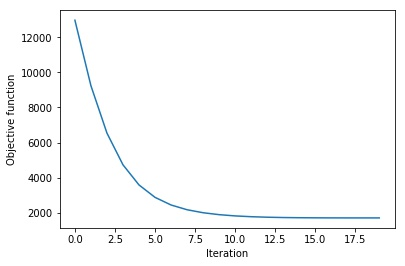

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
import matplotlib.pyplot as plt

plt.figure()
plt.plot(model.error)
plt.xlabel("Iteration")
plt.ylabel("Objective function")

Let's compare the model and the original data.

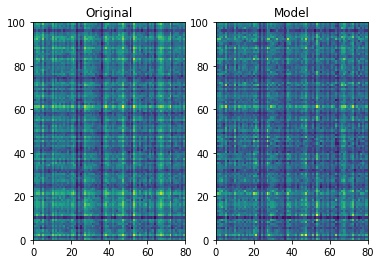

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].pcolor(X)
ax[0].set_title("Original")

ax[1].pcolor(model.predict_all())
ax[1].set_title("Model")
plt.show()

We calculate the explained variance.

In [7]:
Xp = model.predict_all()
expl_var = (np.var(X) - np.var(X-Xp))/np.var(X)
expl_var

0.58622826167578668

##### Question 6-1-2
How does the explained variance change with the rang of the model, no. of iterations?

In [8]:
for rank in range(3, 10):
    model = NMF(rank=rank, max_iter=20, eta=0.001)
    model.fit(X)
    Xp = model.predict_all()
    expl_var = (np.var(X) - np.var(X-Xp))/np.var(X)
    print(rank, expl_var)

3 0.333709259708
4 0.511401434841
5 0.502258639665
6 0.653264764706
7 0.629582019203
8 0.698532510613
9 0.697195748425


##### Question 6-1-3
Test the NMF method on the Jester database. The data are divided into a learning and test set, where a share $p$ of ratings is present in the learning set. Run the model on the learning set and calculate the test error (RMSE, explained variance) on estimates that were not used for learning. Calculate how the test error varies depending on:
* the share of learning estimates of $p$,
* rank matrix of the model (number $r$, parameter ```rank```)

In [9]:
# Naložimo podatkovno zbirko Jester z 1% upoštevanih ocen
def load_jester(p=0.05):
    """
    :param p: Probability of rating appearing in the training set.
    :return
        X training grades (retining with probability p)
        Y test grades (whole dataset) 
    """

    Y = np.genfromtxt("podatki/jester-data.csv", delimiter=",", dtype=float, )
    Y = Y[:, 1:]
    Y[Y == 99] = 0 
    Y[Y != 0]  = Y[Y!=0] + abs(Y[Y!=0].min())

    # Separate data in test/train with probability p
    M = np.random.rand(*Y.shape) 
    M_tr = M < p
    M_te = M > p
    X = Y * M_tr
    Y = Y * M_te

    return X, Y

# X: 1% podatkov, Y ostalih 99% 
X, Y = load_jester(p=0.5)

X = X[:1000, :]
Y = Y[:1000, :]
print("X shape:", X.shape)
print("Y shape:", Y.shape)

print("X, Nonzeros:", np.sum(X>0), "Total:", X.shape[0]*X.shape[1])
print("Y, Nonzeros:", np.sum(Y>0), "Total:", Y.shape[0]*Y.shape[1])

X shape: (1000, 100)
Y shape: (1000, 100)
X, Nonzeros: 35807 Total: 100000
Y, Nonzeros: 35538 Total: 100000


In [10]:
model = NMF(rank=10, max_iter=100, eta=0.001)
model.fit(X)
Yp = model.predict_all()

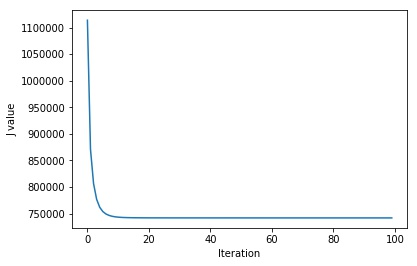

In [11]:
plt.figure()
plt.plot(model.error)
plt.xlabel("Iteration")
plt.ylabel("J value")
plt.show()

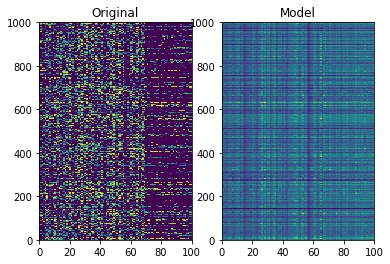

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].pcolor(Y)
ax[0].set_title("Original")

ax[1].pcolor(Yp)
ax[1].set_title("Model")
plt.show()

In [13]:
expl_var = (np.var(Y[Y>0]) - np.var(Y[Y>0] - Yp[Y>0])) / np.var(Y[Y>0])
print(expl_var)

0.207616871733
